This notebook goes through the steps of creating a teleportation circuit and test the circuit. Note that creation of the circuit is based off of what is presented in the Qiskit Textbook: https://qiskit.org/textbook/ch-algorithms/teleportation.html. Some code is direct from the textbook, some code is slightly modified, and some code is original.

**Imports**

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer
from qiskit.visualization import plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector

**Setup**

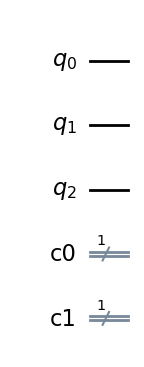

In [2]:
# Create 3 qubits in a register
# q0 will contain the state (psi) that is to be 'teleported' to  target qubit (q2)
# q1 and q2 will become an entangled pair
q_reg = QuantumRegister(3, name = "q")

# Create 2 classical registers for mesaurement of q0 and q1
# These will be used as an intermediate step of 'teleporting' q0 to q2
c_reg_Z = ClassicalRegister(1, name = "c0")
c_reg_X = ClassicalRegister(1, name = "c1")

# Create a circuit from the registers
circuit = QuantumCircuit(q_reg, c_reg_Z, c_reg_X)

circuit.draw()

**Step 1: Entanglement**

In [3]:
# For our entanglement, we will create a Bell Pair 
def make_bell_pair(q_circuit, a, b):
    q_circuit.h(a) # Apply Hadamard to 'a'
    q_circuit.cx(a, b) # Perform c-NOT with 'a' as the control and 'b' as the target 

**Step 2: Alter q1 based on the state of q0**

In [4]:
# We need to perform some operations between our qubit with state psi (q0) and the non-target entangled qubit (q1)
# These operations are the same ones used to create a bell pair, only they are performed in reverse
def alter_psi_entangled(q_circuit, psi, a):
    q_circuit.cx(psi, a) # Perform c-NOT with 'psi' as the control and 'a' as the target 
    q_circuit.h(psi) # Apply Hadamard to 'psi'

**Step 3: Measure q0 and q1, and store them in the classical registers**

In [5]:
def measure_store(q_circuit, psi, a):
    q_circuit.measure(psi, 0) # Measure 'psi' and store in the first classical register
    q_circuit.measure(a, 1) # Measure 'a' and store in the second classical register

**Step 4: Receive psi at q2 based on the states of the classical registers**

In [6]:
# Receive state psi at q2 using data stored in the classical registers
# Performs nothing (or I) on q2 if the classical states are 00
# Performs X on q2 if the classical states are 01
# Performs Z on q2 if the classical states are 10
# Performs ZX on q2 if the classical states are 11
def receive_psi(q_circuit, b, c0, c1):
    q_circuit.x(b).c_if(c1, 1) # If the second classical register is 1, perform the X gate on 'b'
    q_circuit.z(b).c_if(c0, 1) # If the first classical register is 1, perform the Z gate on 'b'

**Teleportation Circuit**

In [7]:
# All steps wrapped up into a single function
def teleportation(q_circuit, c0, c1):
    # Step 1
    make_bell_pair(circuit, 1, 2) # Entangle q1 and q2
    circuit.barrier()

    # Step 2
    alter_psi_entangled(circuit, 0, 1) # Alter q1 based on psi (q0)
    circuit.barrier()

    # Step 3
    measure_store(circuit, 0, 1) # Measure psi (q0) and q1 and store results in classical registers
    circuit.barrier()

    # Step 4
    receive_psi(circuit, 2, c_reg_Z, c_reg_X) # Alter q2 based on the states of the classical registers so that it can be transformed to state psi

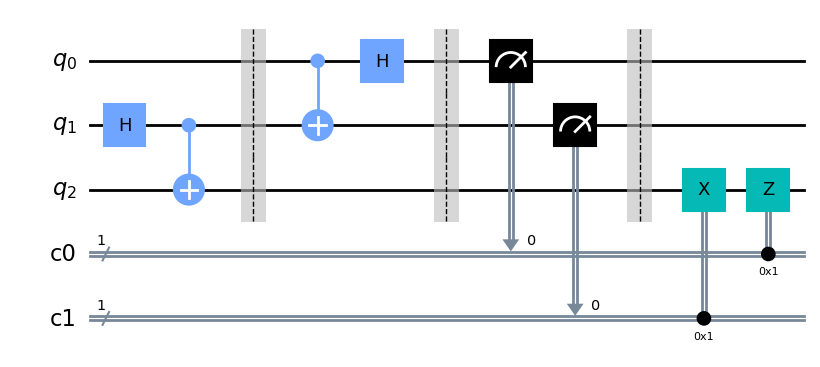

In [8]:
# Call teleportation function using circuit created in Setup
teleportation(circuit, c_reg_Z, c_reg_X)

# Draw teleportation circuit
circuit.draw()

**Check state of q2 based on psi (q0) being state 0**

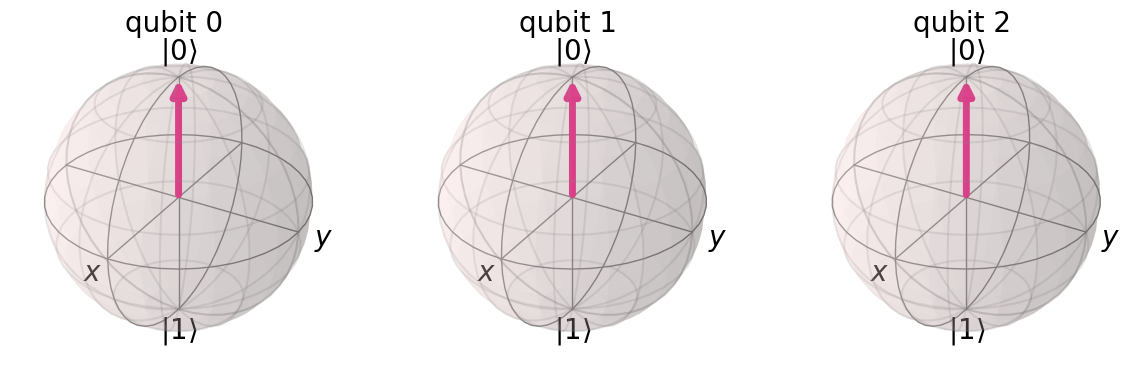

In [9]:
# Simulate the circuit
sim = Aer.get_backend('aer_simulator')
circuit.save_statevector()
out_vector = sim.run(circuit).result().get_statevector()

# Display the states on bloch spheres
plot_bloch_multivector(out_vector)

As can be seen above, q0 began in state 0 which is the state that q2 is in at the end. Of course, all qubits begin in state 0 and so this isn't all that interesting. We will try with some different states.

**Check state of q2 based on psi (q0) being state 1**

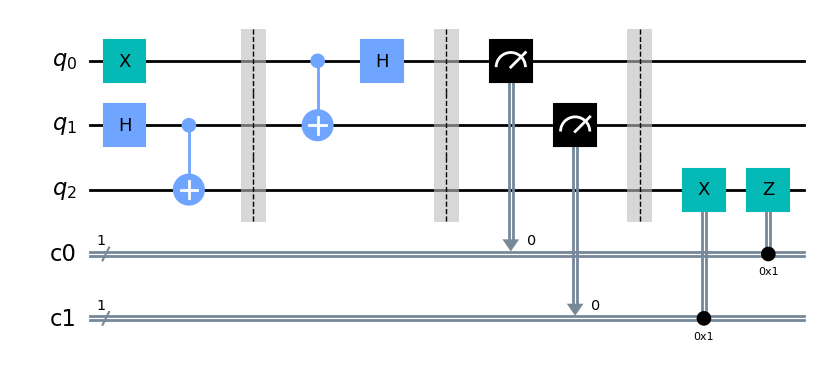

In [10]:
# Reset circuit
q_reg = QuantumRegister(3, name = "q")
c_reg_Z = ClassicalRegister(1, name = "c0")
c_reg_X = ClassicalRegister(1, name = "c1")
circuit = QuantumCircuit(q_reg, c_reg_Z, c_reg_X)

# Set q0 to state 1
circuit.x(0)

# Perform teleportation
teleportation(circuit, c_reg_Z, c_reg_X)

# Draw
circuit.draw()

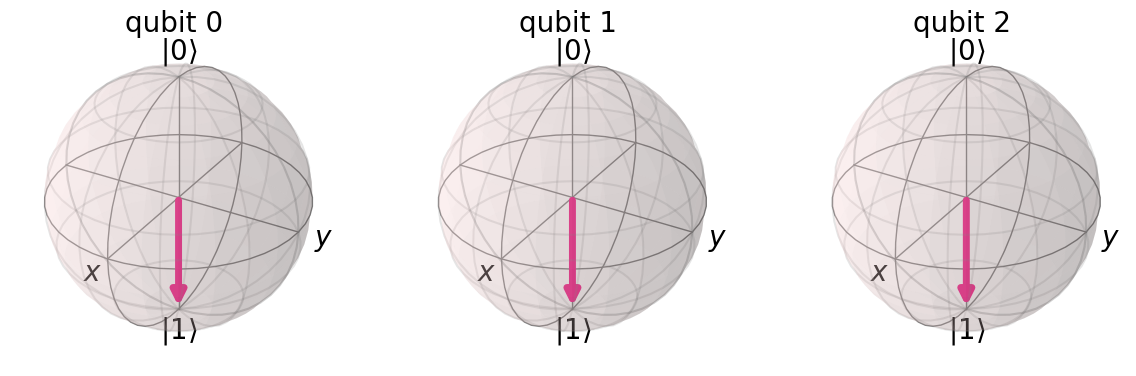

In [11]:
# Simulate the circuit
sim = Aer.get_backend('aer_simulator')
circuit.save_statevector()
out_vector = sim.run(circuit).result().get_statevector()

# Display the states on bloch spheres
plot_bloch_multivector(out_vector)

Once again, we have teleported state q0 to q2. Now for a more complex test.

**Check state of q2 on psi being a random state**

<IPython.core.display.Latex object>

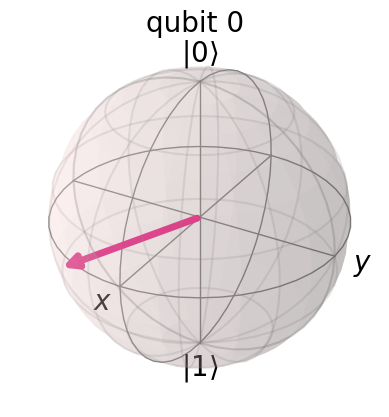

In [12]:
# Generate random state
psi = random_statevector(2)

# Display state
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))

# Display state on bloch sphere
plot_bloch_multivector(psi)

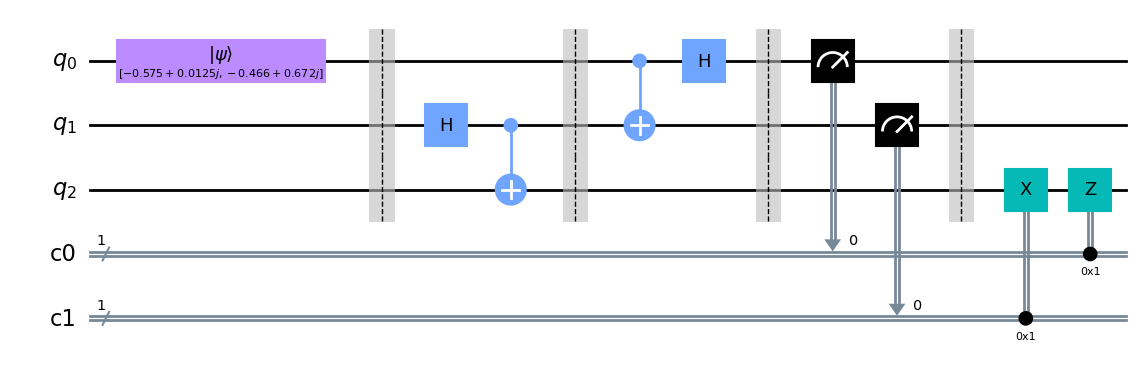

In [13]:
# Reset circuit
q_reg = QuantumRegister(3, name = "q")
c_reg_Z = ClassicalRegister(1, name = "c0")
c_reg_X = ClassicalRegister(1, name = "c1")
circuit = QuantumCircuit(q_reg, c_reg_Z, c_reg_X)

# Set q0 to state psi
circuit.append(Initialize(psi), [0])
circuit.barrier()

# Perform teleportation
teleportation(circuit, c_reg_Z, c_reg_X)

# Draw
circuit.draw()

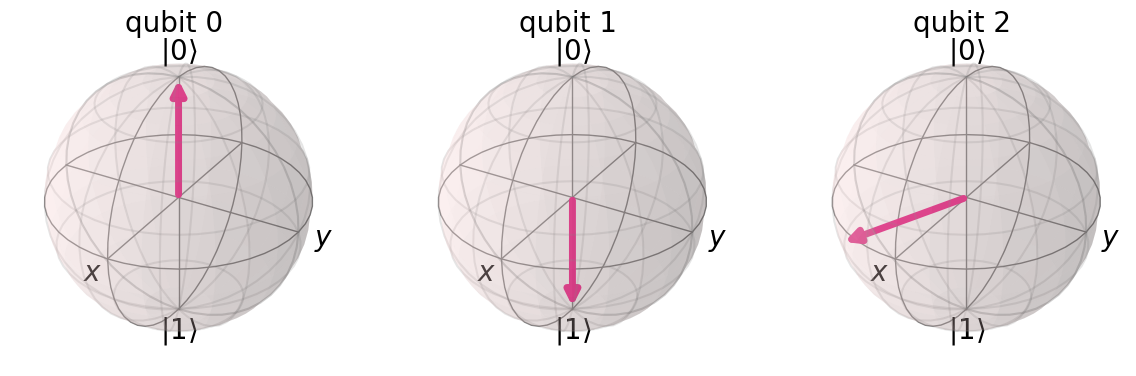

In [14]:
# Simulate the circuit
sim = Aer.get_backend('aer_simulator')
circuit.save_statevector()
out_vector = sim.run(circuit).result().get_statevector()

# Display the states on bloch spheres
plot_bloch_multivector(out_vector)

We can now see that q2 is transformed to the state psi that was once held by q0. In contrast, q0 has been transformed into one of the basis states. Thus, our teleportation circuit works.